In [1]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
from sklearn.decomposition import PCA
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
my_csv = pd.read_csv("weatherAUS.csv")
print(my_csv.head())

         Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
1  2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
2  2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
3  2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
4  2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am      ...      Humidity3pm  \
0           W           44.0          W      ...             22.0   
1         WNW           44.0        NNW      ...             25.0   
2         WSW           46.0          W      ...             30.0   
3          NE           24.0         SE      ...             16.0   
4           W           41.0        ENE      ...             33.0   

   Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  \
0       1007.7       1007.1       8.0     

No     0.775819
Yes    0.224181
Name: RainTomorrow, dtype: float64


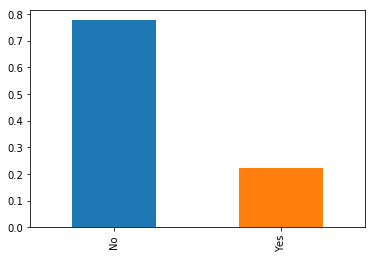

In [3]:
print(my_csv['RainTomorrow'].value_counts(normalize=True))
my_csv['RainTomorrow'].value_counts(normalize=True).plot(kind='bar')
# As we can see, if the model just guesses 'No' all the time, the success rate would be about 77.5% (model 0) 

# Data Processing:

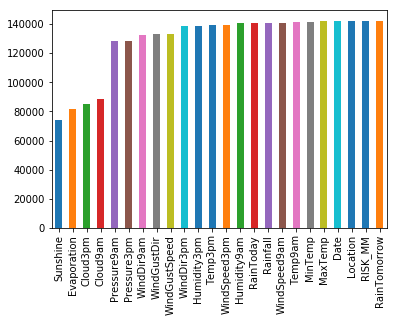

In [4]:
my_csv.count().sort_values().plot(kind='bar')

As we can see the Sunshine, Evaporation, Cloud3pm and Cloud9am dont have many values in them(Less then 60%) so i will ignore them.


In [5]:
my_csv = my_csv.drop(columns=['Sunshine', 'Evaporation', 'Cloud3pm', 'Cloud9am', 'Location', 'RISK_MM', 'Date'], axis=1)

In [6]:
print(my_csv.shape)

(142193, 17)


In [7]:
my_csv = my_csv.dropna(how='any')

Removing the outliers

In [8]:
# Finding the zscore 
z = np.abs(stats.zscore(my_csv.select_dtypes(include=[np.number])))
print(z)
# Actually removing the outliers (zscore>3)
my_csv = my_csv[(z < 3).all(axis=1)]
print(my_csv)

[[0.11756741 0.10822071 0.20666127 ... 1.14245477 0.08843526 0.04787026]
 [0.84180219 0.20684494 0.27640495 ... 1.04184813 0.04122846 0.31776848]
 [0.03761995 0.29277194 0.27640495 ... 0.91249673 0.55672435 0.15688743]
 ...
 [1.44940294 0.23548728 0.27640495 ... 0.58223051 1.03257127 0.34701958]
 [1.16159206 0.46462594 0.27640495 ... 0.25166583 0.78080166 0.58102838]
 [0.77784422 0.4789471  0.27640495 ... 0.2085487  0.37167606 0.56640283]]
        MinTemp  MaxTemp  Rainfall WindGustDir  WindGustSpeed WindDir9am  \
0          13.4     22.9       0.6           W           44.0          W   
1           7.4     25.1       0.0         WNW           44.0        NNW   
2          12.9     25.7       0.0         WSW           46.0          W   
3           9.2     28.0       0.0          NE           24.0         SE   
4          17.5     32.3       1.0           W           41.0        ENE   
5          14.6     29.7       0.2         WNW           56.0          W   
6          14.3     25.0

Replacing the non numeric values to be able to use them

In [9]:
my_csv['RainToday'].replace({'No': 0, 'Yes': 1}, inplace=True)
my_csv['RainTomorrow'].replace({'No': 0, 'Yes': 1}, inplace=True)

In [10]:
for col in ['WindGustDir', 'WindDir3pm', 'WindDir9am']:
    print(np.unique(my_csv[col]))

['E' 'ENE' 'ESE' 'N' 'NE' 'NNE' 'NNW' 'NW' 'S' 'SE' 'SSE' 'SSW' 'SW' 'W'
 'WNW' 'WSW']
['E' 'ENE' 'ESE' 'N' 'NE' 'NNE' 'NNW' 'NW' 'S' 'SE' 'SSE' 'SSW' 'SW' 'W'
 'WNW' 'WSW']
['E' 'ENE' 'ESE' 'N' 'NE' 'NNE' 'NNW' 'NW' 'S' 'SE' 'SSE' 'SSW' 'SW' 'W'
 'WNW' 'WSW']


In [11]:
my_csv = pd.get_dummies(my_csv, columns=['WindGustDir', 'WindDir3pm', 'WindDir9am'])
print(my_csv.head())

   MinTemp  MaxTemp  Rainfall  WindGustSpeed  WindSpeed9am  WindSpeed3pm  \
0     13.4     22.9       0.6           44.0          20.0          24.0   
1      7.4     25.1       0.0           44.0           4.0          22.0   
2     12.9     25.7       0.0           46.0          19.0          26.0   
3      9.2     28.0       0.0           24.0          11.0           9.0   
4     17.5     32.3       1.0           41.0           7.0          20.0   

   Humidity9am  Humidity3pm  Pressure9am  Pressure3pm       ...        \
0         71.0         22.0       1007.7       1007.1       ...         
1         44.0         25.0       1010.6       1007.8       ...         
2         38.0         30.0       1007.6       1008.7       ...         
3         45.0         16.0       1017.6       1012.8       ...         
4         82.0         33.0       1010.8       1006.0       ...         

   WindDir9am_NNW  WindDir9am_NW  WindDir9am_S  WindDir9am_SE  WindDir9am_SSE  \
0               0      

# Using pca to determine the n best classifiers (to dercrease runtime and improve accuracy)

In [12]:
X = my_csv.loc[:, my_csv.columns != 'RainTomorrow']
y = my_csv[['RainTomorrow']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

(107868, 62)
[5.25740274e-01 1.85071051e-01 1.06495815e-01 8.04299404e-02
 3.77649046e-02 2.49740614e-02 2.06199055e-02 9.81905022e-03
 4.47101588e-03 1.14460807e-03 9.46160731e-04 3.78596336e-04
 9.40954775e-05 8.41570176e-05 7.92286425e-05 7.18637679e-05
 6.96701878e-05 6.39391731e-05 6.23300956e-05 6.03539143e-05
 5.74601856e-05 5.61402523e-05 5.54646807e-05 5.42215628e-05
 5.38432305e-05 5.22055042e-05 5.19364300e-05 5.08763341e-05
 4.98329976e-05 4.95042765e-05 4.90436378e-05 4.84387609e-05
 4.64768101e-05 4.54518995e-05 4.54124809e-05 4.49655171e-05
 4.47250240e-05 4.39946734e-05 4.32371237e-05 4.24943055e-05
 4.24144379e-05 4.18216733e-05 4.16828490e-05 3.99472437e-05
 3.89921861e-05 3.80888544e-05 3.67550195e-05 3.65036551e-05
 3.56088973e-05 3.51672887e-05 3.12240902e-05 3.02706290e-05
 2.81684873e-05 2.39611401e-05 2.31867930e-05 2.24653809e-05
 1.40079346e-05 1.29859628e-05 1.03683987e-31 2.76431849e-33
 2.31854495e-35]


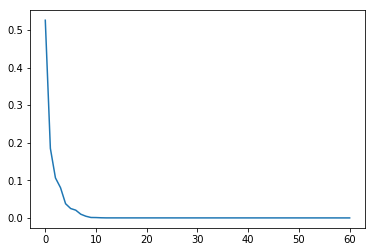

In [13]:
print(my_csv.shape)
pca_visual = PCA()
X_train_visual = pca_visual.fit_transform(X_train)
X_test_visual = pca_visual.transform(X_test)
fit_visual = pca_visual.fit(X)
print(fit_visual.explained_variance_ratio_)
plt.plot(fit_visual.explained_variance_ratio_)

In [14]:
pca = PCA(n_components=4)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
fit = pca.fit(X)
# summarize components
print(fit.explained_variance_ratio_)

[0.52574027 0.18507105 0.10649581 0.08042994]


# Adaboosting algorithem

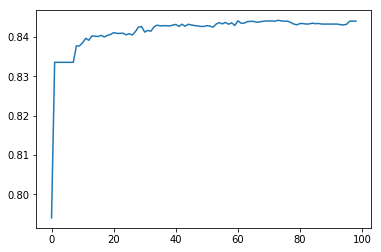

In [15]:
visual_arr = []
for i in range(1,100):
    adaboost_visual = AdaBoostClassifier(n_estimators=i, base_estimator= None,learning_rate=1, random_state = 1)
    adaboost_visual.fit(X_train,y_train)
    y_pred_visual = adaboost_visual.predict(X_test)
    cm = confusion_matrix(y_test,y_pred_visual)
    accuracy = float(cm.diagonal().sum())/len(y_test)
    visual_arr.append(accuracy)
plt.plot(visual_arr)

As we can see in the graph above, the accuracy with n n_estimators when n goes to 100 goes to ~84
thats why i will choose n=100 to minimize runtime. 

In [16]:
adaboost = AdaBoostClassifier(n_estimators=100, base_estimator= None,learning_rate=1, random_state = 1)
adaboost.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
          n_estimators=100, random_state=1)

In [17]:
y_pred = adaboost.predict(X_test)
cm = confusion_matrix(y_test,y_pred)
accuracy = float(cm.diagonal().sum())/len(y_test)
print("\nAccuracy Of AdaBoost For The Given Dataset : ", accuracy)
print("\nF-score wighted : ", f1_score(y_test,y_pred,average='weighted'))


Accuracy Of AdaBoost For The Given Dataset :  0.8440252155372208

F-score wighted :  0.8288045636537805


The adaboosting algorithem gives us a better result then the 0 nodel by about 8% (~84 to ~77)